In [1]:
import os
import pandas as pd

basel_dataset = pd.read_csv(os.path.join("dataset", "sorted", "BASEL.csv"))
basel_dataset


,DATE,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,BASEL_temp_max
0,20000101,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,3.9
1,20000102,0.87,1.0318,0.25,0.00,0.0,3.6,2.7,4.8
2,20000103,0.81,1.0314,0.50,0.00,3.7,2.2,0.1,4.8
3,20000104,0.79,1.0262,0.63,0.35,6.9,3.9,0.5,7.5
4,20000105,0.90,1.0246,0.51,0.07,3.7,6.0,3.8,8.6
...,...,...,...,...,...,...,...,...,...
3649,20091228,0.82,1.0084,0.28,0.42,0.3,3.2,1.0,4.8
3650,20091229,0.92,1.0028,0.22,1.68,0.2,4.5,2.4,10.0
3651,20091230,0.92,0.9979,0.07,1.54,0.0,8.5,7.5,11.5
3652,20091231,0.93,0.9958,0.17,0.57,0.1,6.6,4.3,7.9


In [2]:
import tensorflow as tf

TRAIN_END_INDEX = 2922
VALIDATION_END_INDEX = 3288


def get_dataset(
    dataset: pd.DataFrame,
    sequence_length,
    delay,
    batch_size,
    train_end_index,
    validation_end_index,
):
    data = dataset
    for col in dataset.columns:
        if "temp_mean" in col:
            target = pd.DataFrame(dataset[col])
            data = data.drop(columns=["DATE"])
            break
    scaled_data = (data - data.mean(axis=0)) / data.std(axis=0)
    train_dataset = tf.keras.utils.timeseries_dataset_from_array(
        scaled_data[:-delay],
        targets=target[delay:],
        sequence_length=sequence_length,
        batch_size=batch_size,
        start_index=0,
        end_index=train_end_index,
    )
    validation_dataset = tf.keras.utils.timeseries_dataset_from_array(
        scaled_data[:-delay],
        targets=target[delay:],
        sequence_length=sequence_length,
        batch_size=batch_size,
        start_index=train_end_index,
        end_index=validation_end_index,
    )
    test_dataset = tf.keras.utils.timeseries_dataset_from_array(
        scaled_data[:-delay],
        targets=target[delay:],
        sequence_length=sequence_length,
        batch_size=batch_size,
        start_index=validation_end_index,
    )
    return (train_dataset, validation_dataset, test_dataset)


(train_dataset, validation_dataset, test_dataset) = get_dataset(
    basel_dataset, 5, 1, 32, TRAIN_END_INDEX, VALIDATION_END_INDEX
)
train_dataset


2022-11-04 14:53:01.375265: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-04 14:53:01.632670: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-04 14:53:02.342753: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-04 14:53:02.342848: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

<BatchDataset element_spec=(TensorSpec(shape=(None, None, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

In [6]:
def get_simple_lstm(sequence_length, feature_length):
    model_in = tf.keras.Input((sequence_length, feature_length))
    x = tf.keras.layers.LSTM(16)(model_in)
    model_out = tf.keras.layers.Dense(1)(x)
    return tf.keras.Model(inputs=[model_in], outputs=[model_out])


model = get_simple_lstm(5, 8)
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 8)]            0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                1600      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,617
Trainable params: 1,617
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.compile("rmsprop", "MSE", ["MAE"])


In [18]:
max_epoch = 20
history = model.fit(train_dataset, epochs=max_epoch, validation_data=validation_dataset)


Epoch 1/20
92/92 [==============================] - 2s 21ms/step - loss: 138.7941 - MAE: 10.2292 - val_loss: 112.9045 - val_MAE: 9.2123
Epoch 2/20
92/92 [==============================] - 2s 17ms/step - loss: 103.4770 - MAE: 8.8310 - val_loss: 80.7210 - val_MAE: 7.7189
Epoch 3/20
92/92 [==============================] - 1s 16ms/step - loss: 72.2158 - MAE: 7.1501 - val_loss: 52.0845 - val_MAE: 5.7174
Epoch 4/20
92/92 [==============================] - 1s 16ms/step - loss: 49.3084 - MAE: 5.4248 - val_loss: 37.0964 - val_MAE: 4.4527
Epoch 5/20
92/92 [==============================] - 1s 16ms/step - loss: 37.4103 - MAE: 4.5087 - val_loss: 29.2195 - val_MAE: 3.9129
Epoch 6/20
92/92 [==============================] - 2s 17ms/step - loss: 30.2603 - MAE: 4.0158 - val_loss: 23.6719 - val_MAE: 3.5473
Epoch 7/20
92/92 [==============================] - 1s 16ms/step - loss: 24.7899 - MAE: 3.5959 - val_loss: 19.2007 - val_MAE: 3.1998
Epoch 8/20
92/92 [==============================] - 1s 16ms/step 

12/12 [==============================] - 0s 12ms/step


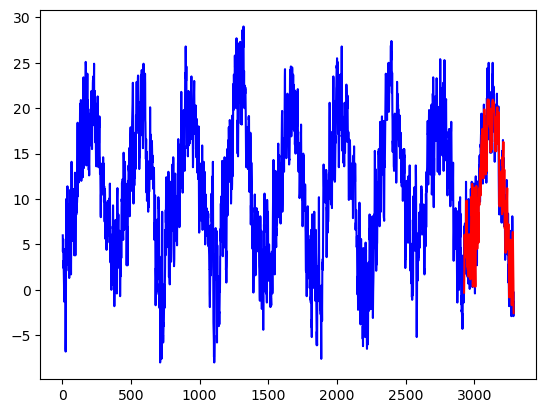

In [54]:
import matplotlib.pyplot as plt
val_predictions = model.predict(validation_dataset)
import numpy as np
plt.plot(
    range(4, VALIDATION_END_INDEX),
    basel_dataset.iloc[4 : VALIDATION_END_INDEX, 6],
    "b",
)
plt.plot(range(TRAIN_END_INDEX+4, VALIDATION_END_INDEX), val_predictions[:, 0], "r")
plt.show()


In [23]:
predictions = model.predict(validation_dataset)
predictions.shape


12/12 [==============================] - 0s 8ms/step


(362, 1)

In [ ]:
for i in range(len(basel_dataset.index)):
    if "2008" in str(basel_dataset.iloc[i, 0]):
        print(i)
        break


2922


In [ ]:
basel_dataset[2921:]


,DATE,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,BASEL_temp_max
2921,20071231,0.86,1.0311,0.49,0.00,1.3,0.9,-2.4,4.9
2922,20080101,0.86,1.0257,0.22,0.00,0.0,-0.5,-2.2,0.9
2923,20080102,0.67,1.0181,0.25,0.00,0.0,-1.4,-2.1,-0.8
2924,20080103,0.68,1.0076,0.28,0.00,0.1,-0.5,-3.1,3.2
2925,20080104,0.80,1.0131,0.14,0.00,0.0,-0.3,-3.6,2.3
...,...,...,...,...,...,...,...,...,...
3649,20091228,0.82,1.0084,0.28,0.42,0.3,3.2,1.0,4.8
3650,20091229,0.92,1.0028,0.22,1.68,0.2,4.5,2.4,10.0
3651,20091230,0.92,0.9979,0.07,1.54,0.0,8.5,7.5,11.5
3652,20091231,0.93,0.9958,0.17,0.57,0.1,6.6,4.3,7.9


In [ ]:
import numpy as np


def evaluate_naive_method(dataset):
    total_abs_err = 0
    data_seen = 0
    train_std = basel_dataset["BASEL_temp_mean"].std()
    train_mean = basel_dataset["BASEL_temp_mean"].mean()
    for data, label in dataset:
        preds = data[:, -1, 6] * train_std + train_mean
        total_abs_err += np.sum(np.abs(preds - label))
        data_seen += data.shape[0]
    return total_abs_err / data_seen


print("Navie Method Validation MAE:", evaluate_naive_method(validation_dataset))


Navie Method Validation MAE: 112.17374882092733


In [ ]:
for data, label in validation_dataset:
    print(data.shape)


(32, 5, 8)
(32, 5, 8)
(32, 5, 8)
(32, 5, 8)
(32, 5, 8)
(32, 5, 8)
(32, 5, 8)
(32, 5, 8)
(32, 5, 8)
(32, 5, 8)
(32, 5, 8)
(10, 5, 8)
